<a href="https://colab.research.google.com/github/joezein71/AIHC-5010-Winter-2026/blob/main/20260122_Assignment1_Colab_Workflow_Zein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 — Colab Workflow (GitHub + Pre-commit + Submission Validation)

This notebook teaches the standard workflow used throughout the course:

1. Clone your team repo
2. Install dependencies
3. Install **pre-commit** and enable a hook to strip notebook outputs
4. Run this notebook end-to-end
5. Validate `predictions.csv`
6. Commit + push + tag


In [1]:
# (Colab) show python and system info
import sys, platform
print(sys.version)
print(platform.platform())


3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Linux-6.6.105+-x86_64-with-glibc2.35


## 1) Clone Repo

Login to your personal Github account, and make a fork of: https://github.com/TLKline/AIHC-5010-Winter-2026

Follow setup directions for working with a PAT in GitHub (30-second guide):

* Go to GitHub → Settings
* Developer settings
* Personal access tokens
* Choose:
  * Fine-Grained

You can clone using HTTPS.

Repo HTTPS URL (e.g., `https://github.com/TLKline/AIHC-5010-Winter-2026.git`)

In [2]:
# TODO: Change the following to your github repo path
repo_path = 'https://github.com/joezein71/AIHC-5010-Winter-2026.git'
!git clone {repo_path} student_repo

Cloning into 'student_repo'...
remote: Enumerating objects: 327, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 327 (delta 32), reused 21 (delta 21), pack-reused 287 (from 2)
Receiving objects: 100% (327/327), 10.24 MiB | 16.06 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [3]:
# Move into repo
%cd student_repo

# Repo git info
!git status

# Where are we?
print('----------')
print('We are at:')
!pwd


/content/student_repo
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
----------
We are at:
/content/student_repo


## 2) Install dependencies

This installs whatever is in `requirements.txt`.


In [4]:
!pip -q install -r Project-1/readmit30/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.4/226.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.5 MB/s eta 0:00:00


## 3) Enable pre-commit hook to strip notebook outputs

This prevents giant notebooks and reduces merge/diff pain.

One-time per clone:
- `pre-commit install`

After that, every `git commit` will strip outputs from `*.ipynb`.


In [5]:
!pip -q install pre-commit
!pre-commit install


pre-commit installed at .git/hooks/pre-commit


#MAINSTART

# 4) Submission Notebook (Template)

Replace the baseline model with your team’s approach.

In [6]:
import os
from pathlib import Path

TRAIN_PATH = os.environ.get("TRAIN_PATH", "Project-1/readmit30/scripts/data/public/train.csv")
DEV_PATH   = os.environ.get("DEV_PATH",   "Project-1/readmit30/scripts/data/public/dev.csv")
TEST_PATH  = os.environ.get("TEST_PATH",  "Project-1/readmit30/scripts/data/public/public_test.csv")
OUT_PATH   = os.environ.get("OUT_PATH",   "predictions.csv")

print("TRAIN_PATH:", TRAIN_PATH)
print("DEV_PATH:", DEV_PATH)
print("TEST_PATH:", TEST_PATH)
print("OUT_PATH:", OUT_PATH)

TRAIN_PATH: Project-1/readmit30/scripts/data/public/train.csv
DEV_PATH: Project-1/readmit30/scripts/data/public/dev.csv
TEST_PATH: Project-1/readmit30/scripts/data/public/public_test.csv
OUT_PATH: predictions.csv


# Also changing "?" and "Unknown/Invalid" to missing

In [17]:
import numpy as np
import pandas as pd
np.random.seed(42)

train = pd.read_csv(TRAIN_PATH, na_values=['?', 'Unknown/Invalid'])
test = pd.read_csv(TEST_PATH, na_values=['?', 'Unknown/Invalid'])

assert "row_id" in train.columns and "readmit30" in train.columns
assert "row_id" in test.columns

X_train = train.drop(columns=["readmit30"])
y_train = train["readmit30"].astype(int)

# **EDA Assignment**

# **1- Basic dataset snapshot**
       - Rows x colums
       - Outcomes columns names and overall readmission rate
       - Data types summary

- Data dimension: rows x colums

In [23]:
print(f"Dimensions of training data (train): {train.shape[0]} rows, {train.shape[1]} columns")
print(f"Dimensions of training features (X_train): {X_train.shape[0]} rows, {X_train.shape[1]} columns")
print(f"Dimensions of test data: {test.shape[0]} rows, {test.shape[1]} columns")

Dimensions of training data (train): 65003 rows, 51 columns
Dimensions of training features (X_train): 65003 rows, 50 columns
Dimensions of test data: 16314 rows, 50 columns


Outcomes (readmission rate at 30 days)

In [24]:
overall_readmission_rate = y_train.mean()
print(f"Overall Readmission Rate (readmit30): {overall_readmission_rate:.4f}")

Overall Readmission Rate (readmit30): 0.1116


Data Types (numeric vs. categorical)

In [27]:
print("Summary Statistics for Numeric Columns in X_train:")

# Select only numeric columns
numeric_columns = X_train.select_dtypes(include=np.number)

display(numeric_columns.describe())

Summary Statistics for Numeric Columns in X_train:


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,row_id
count,6.500300e+04,6.500300e+04,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,6.500300e+04
mean,1.652766e+08,5.440774e+07,2.022537,3.714152,5.740120,4.376660,43.027553,1.334769,15.983216,0.366383,0.199698,0.627417,7.421704,1.652766e+08
std,1.025533e+08,3.867605e+07,1.444042,5.289158,4.061814,2.968984,19.655092,1.700345,8.069052,1.253617,0.989302,1.247288,1.933656,1.025533e+08
min,1.252200e+04,7.290000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.252200e+04
25%,8.549013e+07,2.343626e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,8.549013e+07
50%,1.524313e+08,4.551559e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,1.524313e+08
75%,2.302720e+08,8.771662e+07,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,2.302720e+08
max,4.438672e+08,1.894815e+08,8.000000,28.000000,25.000000,14.000000,129.000000,6.000000,81.000000,40.000000,76.000000,21.000000,16.000000,4.438672e+08


In [26]:
print("Data Types and Non-Null Counts for X_train:")
X_train.info()

Data Types and Non-Null Counts for X_train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65003 entries, 0 to 65002
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              65003 non-null  int64 
 1   patient_nbr               65003 non-null  int64 
 2   race                      63532 non-null  object
 3   gender                    65001 non-null  object
 4   age                       65003 non-null  object
 5   weight                    1985 non-null   object
 6   admission_type_id         65003 non-null  int64 
 7   discharge_disposition_id  65003 non-null  int64 
 8   admission_source_id       65003 non-null  int64 
 9   time_in_hospital          65003 non-null  int64 
 10  payer_code                39270 non-null  object
 11  medical_specialty         33194 non-null  object
 12  num_lab_procedures        65003 non-null  int64 
 13  num_procedures            65003 

In [28]:
print("Variable Type Stratification:")
print("-------------------------------")

continuous_vars = []
integer_vars = []
categorical_vars = []

for col in X_train.columns:
    dtype = X_train[col].dtype
    if pd.api.types.is_float_dtype(dtype): # Check for float types first for continuous
        continuous_vars.append(col)
    elif pd.api.types.is_integer_dtype(dtype): # Check for integer types
        integer_vars.append(col)
    elif pd.api.types.is_object_dtype(dtype) or pd.api.types.is_categorical_dtype(dtype): # Check for object or categorical types
        categorical_vars.append(col)
    # We can add more specific checks for datetime if necessary, but none are identified here

print("Continuous Variables:")
if continuous_vars: print(continuous_vars)
else: print("None")

print("\nInteger Variables:")
if integer_vars: print(integer_vars)
else: print("None")

print("\nCategorical Variables:")
if categorical_vars: print(categorical_vars)
else: print("None")

Variable Type Stratification:
-------------------------------
Continuous Variables:
None

Integer Variables:
['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'row_id']

Categorical Variables:
['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed']


- Summary statistics for continuous variables

In [33]:
print("Summary Statistics for Numeric Columns in X_train:")
numeric_columns_train = X_train.select_dtypes(include=np.number)
display(numeric_columns_train.describe())

Summary Statistics for Numeric Columns in X_train:


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,row_id
count,6.500300e+04,6.500300e+04,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,65003.000000,6.500300e+04
mean,1.652766e+08,5.440774e+07,2.022537,3.714152,5.740120,4.376660,43.027553,1.334769,15.983216,0.366383,0.199698,0.627417,7.421704,1.652766e+08
std,1.025533e+08,3.867605e+07,1.444042,5.289158,4.061814,2.968984,19.655092,1.700345,8.069052,1.253617,0.989302,1.247288,1.933656,1.025533e+08
min,1.252200e+04,7.290000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.252200e+04
25%,8.549013e+07,2.343626e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,8.549013e+07
50%,1.524313e+08,4.551559e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,1.524313e+08
75%,2.302720e+08,8.771662e+07,3.000000,3.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,2.302720e+08
max,4.438672e+08,1.894815e+08,8.000000,28.000000,25.000000,14.000000,129.000000,6.000000,81.000000,40.000000,76.000000,21.000000,16.000000,4.438672e+08


In [34]:
print("\nSummary Statistics for Numeric Columns in test data:")
numeric_columns_test = test.select_dtypes(include=np.number)
display(numeric_columns_test.describe())


Summary Statistics for Numeric Columns in test data:


,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,row_id
count,1.631400e+04,1.631400e+04,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,16314.000000,1.631400e+04
mean,1.640561e+08,5.390431e+07,2.037698,3.734216,5.779576,4.411794,43.282273,1.341363,16.045115,0.354542,0.180029,0.652568,7.424482,1.640561e+08
std,1.021334e+08,3.869201e+07,1.459476,5.327591,4.074607,2.996366,19.762972,1.714745,8.219230,1.170484,0.698899,1.296123,1.922189,1.021334e+08
min,6.225600e+04,1.152000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,6.225600e+04
25%,8.387472e+07,2.334806e+07,1.000000,1.000000,1.000000,2.000000,32.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000,8.387472e+07
50%,1.516305e+08,4.528416e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000,1.516305e+08
75%,2.288984e+08,8.690397e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000,2.288984e+08
max,4.438421e+08,1.893321e+08,8.000000,28.000000,22.000000,14.000000,121.000000,6.000000,70.000000,36.000000,16.000000,19.000000,16.000000,4.438421e+08


- Summary Statistics for categorical variables in both testing and training datasets

In [35]:
print("\nSummary Statistics for Categorical Columns in X_train:")
categorical_columns_train = X_train.select_dtypes(include='object')
display(categorical_columns_train.describe())


Summary Statistics for Categorical Columns in X_train:


,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,63532,65001,65003,1985,39270,33194,64990,64785,64099,3419,...,65003,65003,65003,65003,65003,65003,65003,65003,65003,65003
unique,5,2,10,9,16,69,670,689,729,3,...,1,1,4,4,2,2,2,2,2,2
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,Norm,...,No,No,No,No,No,No,No,No,No,Yes
freq,48447,35011,16725,808,20677,9460,4367,4402,7444,1672,...,65003,65003,30268,64516,64990,65002,65002,65002,35098,50097


In [36]:
print("\nSummary Statistics for Categorical Columns in test data:")
categorical_columns_test = test.select_dtypes(include='object')
display(categorical_columns_test.describe())


Summary Statistics for Categorical Columns in test data:


,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed
count,15932,16313,16314,566,9872,8360,16312,16254,16102,849,...,16314,16314,16314,16314,16314,16314,16314,16314,16314,16314
unique,5,2,10,9,17,56,519,513,535,3,...,1,1,4,3,1,1,1,1,2,2
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,428,250,Norm,...,No,No,No,No,No,No,No,No,No,Yes
freq,12322,8680,4111,246,5187,2362,1112,1122,1799,409,...,16314,16314,7648,16217,16314,16314,16314,16314,8871,12492


# **2- Missingness Audit**
      1 - A table of missingness per column: count missing and % missing, sorted high to low
      2 - A bar plot of the top 15 columns by % missing.
      3 - A short list:
          - 3 columns with acceptable missingness (<5%)
          - 3 columns with problematic missingness (>30%) and your recommended action

1- Table of missingness per column: Count missing and % missing, sorted high to low

In [37]:
print("Missing values in X_train:")
missing_train = X_train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
if not missing_train.empty:
    missing_train_df = pd.DataFrame(missing_train, columns=['Missing Count'])
    missing_train_df['% Missing'] = (missing_train_df['Missing Count'] / len(X_train)) * 100
    display(missing_train_df)
else:
    print("No missing values in X_train.")

print("\nMissing values in test:")
missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
if not missing_test.empty:
    missing_test_df = pd.DataFrame(missing_test, columns=['Missing Count'])
    missing_test_df['% Missing'] = (missing_test_df['Missing Count'] / len(test)) * 100
    display(missing_test_df)
else:
    print("No missing values in test.")

Missing values in X_train:


,Missing Count,% Missing
weight,63018,96.946295
max_glu_serum,61584,94.740243
A1Cresult,54211,83.397689
medical_specialty,31809,48.934665
payer_code,25733,39.587404
race,1471,2.262972
diag_3,904,1.390705
diag_2,218,0.335369
diag_1,13,0.019999
gender,2,0.003077



Missing values in test:


,Missing Count,% Missing
weight,15748,96.530587
max_glu_serum,15465,94.795881
A1Cresult,13514,82.836827
medical_specialty,7954,48.755670
payer_code,6442,39.487557
race,382,2.341547
diag_3,212,1.299497
diag_2,60,0.367782
diag_1,2,0.012259
gender,1,0.006130


2 - A bar plot of the top 15 columns by % missing:
  - ***Only the first 10 variables in the plot include missing value. The next 5 variables were added to the plot although they do not include missing values***

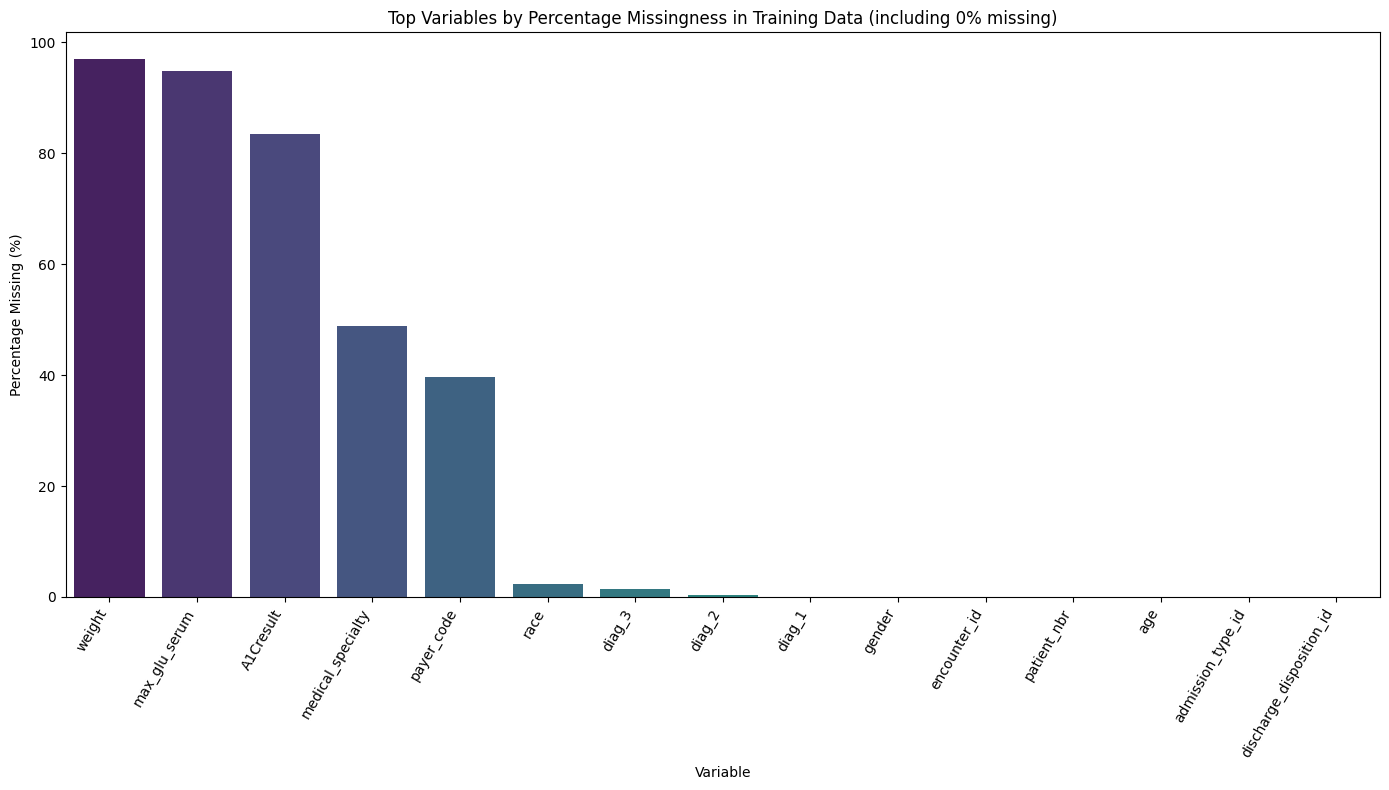

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'missing_train_df' in locals() and not missing_train_df.empty:
    # Get columns with 0% missingness
    zero_missing_cols = X_train.columns[X_train.isnull().sum() == 0].tolist()

    # Exclude columns already in missing_train_df's index
    zero_missing_cols = [col for col in zero_missing_cols if col not in missing_train_df.index]

    # Select the first 5 of these zero-missing columns (or fewer if less than 5 are available)
    additional_cols_for_plot = zero_missing_cols[:5]

    # Create a DataFrame for these additional columns with 0% missing
    if additional_cols_for_plot:
        additional_missing_df = pd.DataFrame({
            'Missing Count': [0] * len(additional_cols_for_plot),
            '% Missing': [0.0] * len(additional_cols_for_plot)
        }, index=additional_cols_for_plot)

        # Combine the original missing_train_df with the additional zero-missing columns
        combined_missing_df = pd.concat([missing_train_df, additional_missing_df])
    else:
        combined_missing_df = missing_train_df

    # Select the top 15 entries from the combined DataFrame
    top_15_for_plot = combined_missing_df.head(15)

    plt.figure(figsize=(14, 8))
    sns.barplot(x=top_15_for_plot.index, y=top_15_for_plot['% Missing'], palette='viridis', hue=top_15_for_plot.index, legend=False)
    plt.title('Top Variables by Percentage Missingness in Training Data (including 0% missing)')
    plt.xlabel('Variable')
    plt.ylabel('Percentage Missing (%)')
    plt.xticks(rotation=60, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("missing_train_df not found or is empty. Please run the missingness audit cells first.")

3 - List of 3 variables with missingness <5% and 3 variables with missingness >30%

In [41]:
print("Summary of Variables by Missingness:")
print("------------------------------------")

if 'missing_train_df' in locals() and not missing_train_df.empty:
    # Variables with <5% missingness
    low_missing_vars = missing_train_df[missing_train_df['% Missing'] < 5].head(3)

    # Variables with >30% missingness
    high_missing_vars = missing_train_df[missing_train_df['% Missing'] > 30].head(3)

    print("\nVariables with <5% Missingness:")
    if not low_missing_vars.empty:
        display(low_missing_vars)
    else:
        print("None found.")

    print("\nVariables with >30% Missingness:")
    if not high_missing_vars.empty:
        display(high_missing_vars)
    else:
        print("None found.")
else:
    print("missing_train_df not found or is empty. Please run the missingness audit cells first.")

Summary of Variables by Missingness:
------------------------------------

Variables with <5% Missingness:


,Missing Count,% Missing
race,1471,2.262972
diag_3,904,1.390705
diag_2,218,0.335369



Variables with >30% Missingness:


,Missing Count,% Missing
weight,63018,96.946295
max_glu_serum,61584,94.740243
A1Cresult,54211,83.397689


2- What is the overall value distribution for some specific variables like 'gender', 'race', 'age', and 'diag_1'?

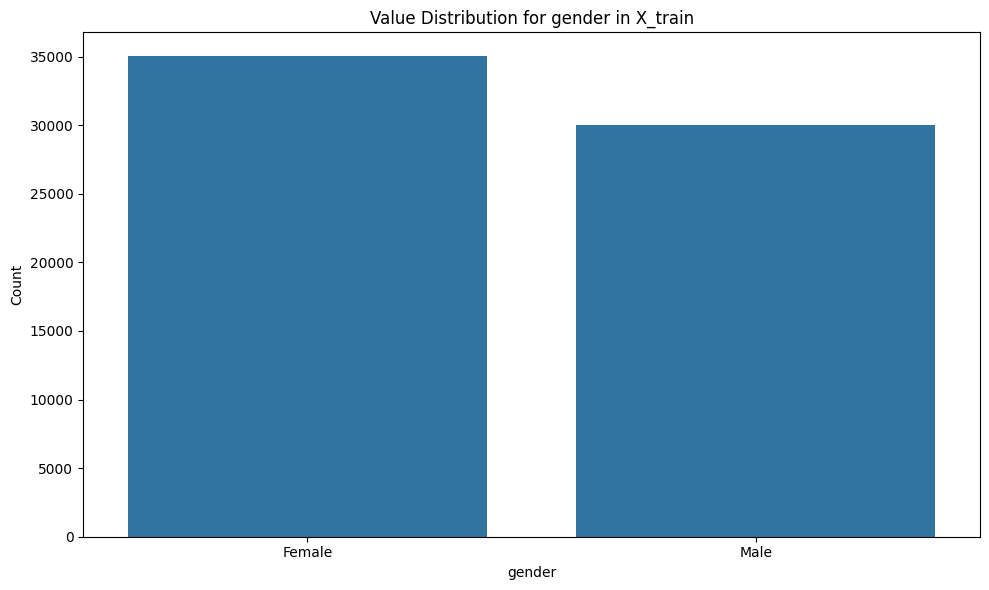

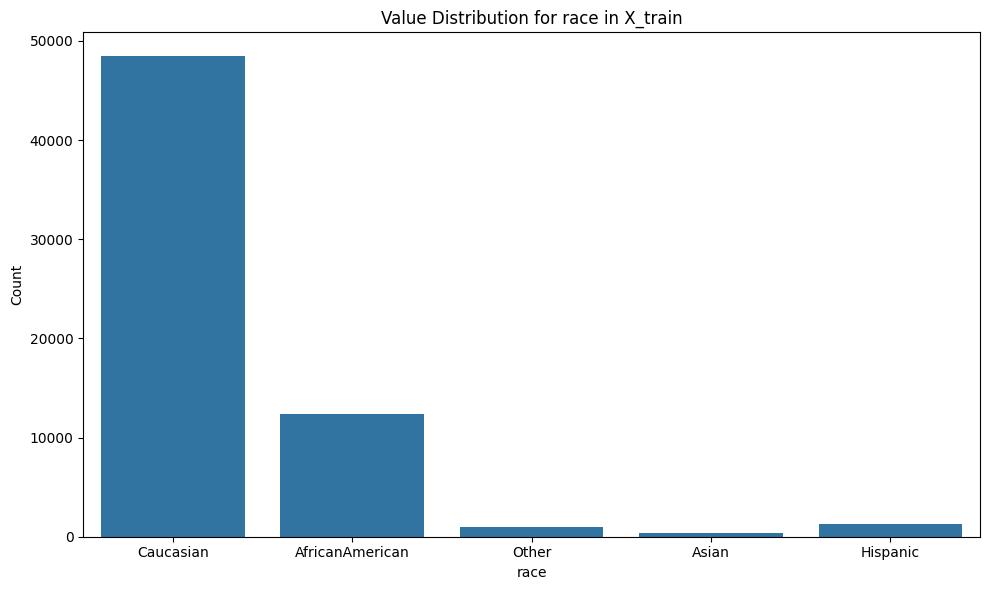

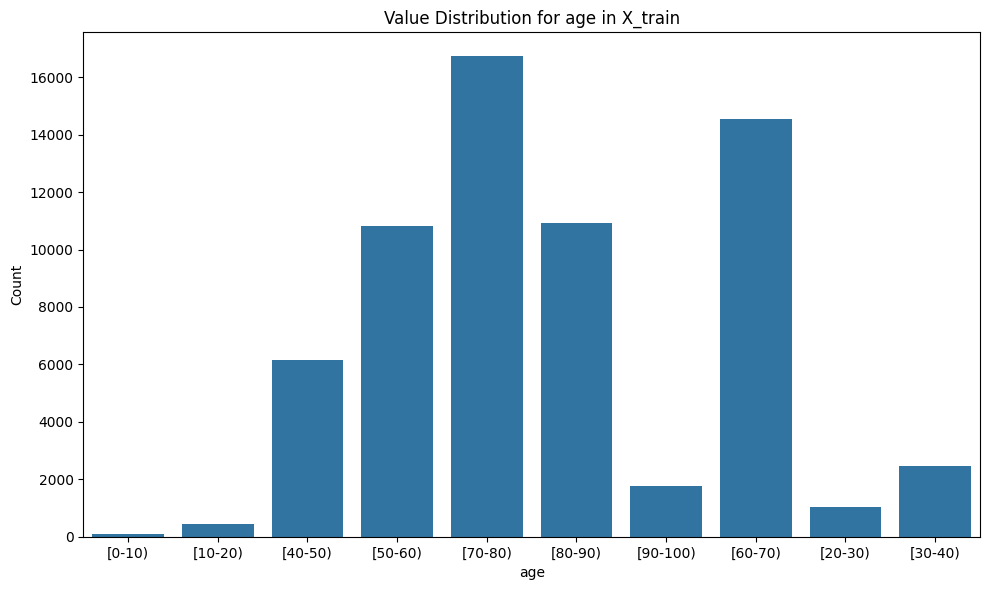

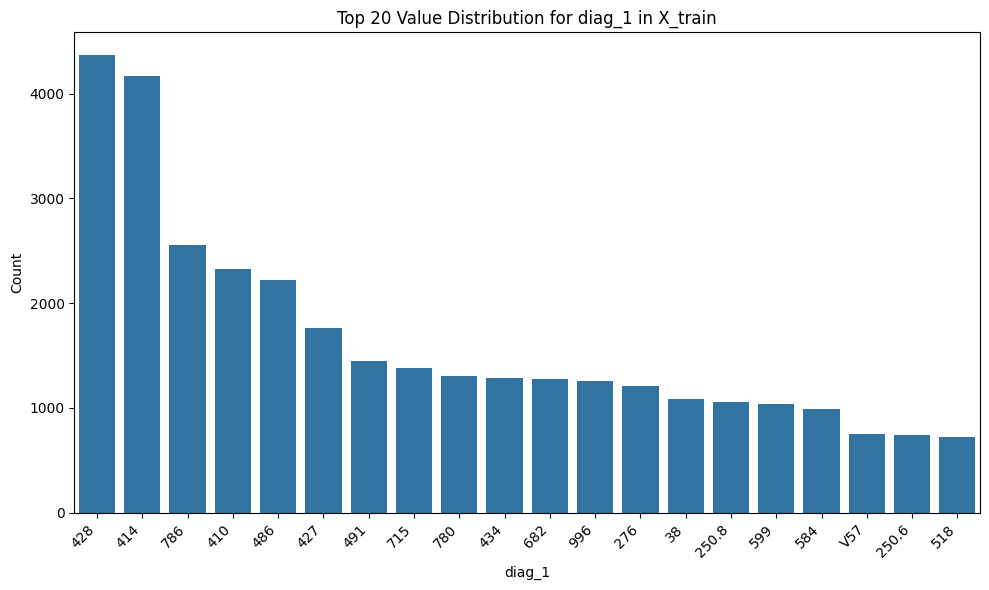

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_plot = ['gender', 'race', 'age', 'diag_1']

for var in variables_to_plot:
    plt.figure(figsize=(10, 6))
    if var == 'diag_1': # Handle potential large number of unique values for diag_1
        top_n = X_train[var].value_counts().nlargest(20)
        sns.barplot(x=top_n.index, y=top_n.values)
        plt.title(f'Top 20 Value Distribution for {var} in X_train')
        plt.xticks(rotation=45, ha='right')
    else:
        sns.countplot(data=X_train, x=var)
        plt.title(f'Value Distribution for {var} in X_train')
    plt.xlabel(var)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 2 - Is missingness related to the readmission outcomes?

In [22]:
import scipy.stats as stats

print("Analyzing missingness in relation to readmission outcomes...")

# Get columns with missing values from X_train
missing_cols_train = X_train.columns[X_train.isnull().any()].tolist()

if not missing_cols_train:
    print("No missing values found in X_train for analysis.")
else:
    results = []
    for col in missing_cols_train:
        # Create a temporary DataFrame with the column, its missing indicator, and the target variable
        temp_df = pd.DataFrame({
            'is_missing': X_train[col].isnull(),
            'readmit30': y_train
        })

        # Calculate counts for contingency table
        missing_readmit_count = temp_df[(temp_df['is_missing'] == True) & (temp_df['readmit30'] == 1)].shape[0]
        missing_non_readmit_count = temp_df[(temp_df['is_missing'] == True) & (temp_df['readmit30'] == 0)].shape[0]
        non_missing_readmit_count = temp_df[(temp_df['is_missing'] == False) & (temp_df['readmit30'] == 1)].shape[0]
        non_missing_non_readmit_count = temp_df[(temp_df['is_missing'] == False) & (temp_df['readmit30'] == 0)].shape[0]

        # Calculate the average readmit30 rate for missing and non-missing groups
        missing_readmit_rate = temp_df[temp_df['is_missing'] == True]['readmit30'].mean()
        non_missing_readmit_rate = temp_df[temp_df['is_missing'] == False]['readmit30'].mean()

        p_value = np.nan
        # Perform Chi-squared test if there are enough observations in each category
        if (missing_readmit_count + missing_non_readmit_count > 0) and \
           (non_missing_readmit_count + non_missing_non_readmit_count > 0) and \
           (missing_readmit_count + non_missing_readmit_count > 0) and \
           (missing_non_readmit_count + non_missing_non_readmit_count > 0):
            contingency_table = [
                [missing_readmit_count, missing_non_readmit_count],
                [non_missing_readmit_count, non_missing_non_readmit_count]
            ]
            # Only perform chi2_contingency if all expected frequencies are >= 5
            # This is a common rule of thumb for the validity of the chi-squared test
            try:
                chi2, p, _, expected = stats.chi2_contingency(contingency_table)
                if np.all(expected >= 5):
                    p_value = p
            except ValueError: # Occurs if table dimensions are zero or contain NaNs
                pass

        results.append({
            'Column': col,
            'Missing Readmit Rate': missing_readmit_rate,
            'Non-Missing Readmit Rate': non_missing_readmit_rate,
            'P-value': p_value
        })

    results_df = pd.DataFrame(results)
    display(results_df.sort_values(by='Missing Readmit Rate', ascending=False))

    print("\nInterpretation: If 'Missing Readmit Rate' is significantly different from 'Non-Missing Readmit Rate' for a given column, then missingness in that column might be related to readmission outcomes. A small P-value (e.g., < 0.05) suggests that the observed difference is statistically significant.")

Analyzing missingness in relation to readmission outcomes...


,Column,Missing Readmit Rate,Non-Missing Readmit Rate,P-value
5,diag_1,0.230769,0.111602,NaN
4,medical_specialty,0.116476,0.106977,1.270379e-04
3,payer_code,0.115299,0.109218,1.661814e-02
9,A1Cresult,0.114479,0.097294,2.465679e-07
2,weight,0.111349,0.120403,2.205547e-01
8,max_glu_serum,0.110889,0.124890,1.232973e-02
0,race,0.080218,0.112353,1.294637e-04
6,diag_2,0.077982,0.111739,1.409176e-01
7,diag_3,0.063053,0.112311,3.892795e-06
1,gender,0.000000,0.111629,NaN



Interpretation: If 'Missing Readmit Rate' is significantly different from 'Non-Missing Readmit Rate' for a given column, then missingness in that column might be related to readmission outcomes. A small P-value (e.g., < 0.05) suggests that the observed difference is statistically significant.


The table above shows the readmission rates when a particular feature is missing versus when it is present. A substantial difference between these two rates could indicate that the missingness itself provides information about the readmission outcome. For instance, if the 'Missing Readmit Rate' for a column is much higher than its 'Non-Missing Readmit Rate', it suggests that patients for whom that data point is absent might have a higher propensity for readmission. This can be a form of *informative missingness*.

# 3.1 Description of the types of variables in the data

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
# TODO: Add any new imports for your own method here
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

method = 4

cat_cols = [c for c in X_train.columns if X_train[c].dtype == "object"]
num_cols = [c for c in X_train.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                          ("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols),
    ],
)

if method==1:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200)),
    ])

if method==2:
    # Use logistic regression model
    clf = Pipeline([
        ("preprocess", preprocess),
        ("model", LogisticRegression(max_iter=200,class_weight='balanced')),
    ])

if method==3:
    # Use SVC (i.e. SVM model)
    clf = Pipeline(
        [
            ("preprocess", preprocess),
            ("scaler", StandardScaler(with_mean=False)), # Add StandardScaler here
            ("model", SVC(gamma="auto",max_iter=1000,probability=True)),
        ]
    )

if method == 4:
    # Preprocess for HGB: ordinal-encode categories (HGB needs numeric inputs)
    preprocess_hgb = ColumnTransformer(
        transformers=[
            ("num", Pipeline([
                ("imputer", SimpleImputer(strategy="median")),
            ]), num_cols),
            ("cat", Pipeline([
                ("imputer", SimpleImputer(strategy="most_frequent")),
                ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
            ]), cat_cols),
        ],
        remainder="drop",
    )

    clf = Pipeline([
        ("preprocess", preprocess_hgb),
        ("model", HistGradientBoostingClassifier(
            max_depth=6,
            learning_rate=0.05,
            max_iter=300,
            l2_regularization=1.0,
            early_stopping=True,
            random_state=42,
            class_weight='balanced',
        )),
    ])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['encounter_id',
                                                   'patient_nbr',
                                                   'admission_type_id',
                                                   'discharge_disposition_id',
                                                   'admission_source_id',
                                                   'time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'numb...
                                                   'acetohexamide', 'glipizide',
                                                   'glyburide', 'tolbutamide',
                                                   'pioglitazone',
                                                   'rosiglitazone', 'acarbose',
                                                   'miglitol', 'troglitazone',
                                                   'tolazamide', 'examide',
                                                   'citoglipton', 'insulin',
                                                   'glyburide-metformin', ...])])),
                ('model',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                early_stopping=True,
                                                l2_regularization=1.0,
                                                learning_rate=0.05, max_depth=6,
                                                max_iter=300,
                                                random_state=42))])

In [9]:
p_test = clf.predict_proba(test)[:, 1]
pred = pd.DataFrame({"row_id": test["row_id"].astype(int), "prob_readmit30": p_test.astype(float)})
pred.to_csv(OUT_PATH, index=False)
pred.head()

,row_id,prob_readmit30
0,103521306,0.561462
1,127919112,0.704297
2,233245326,0.628062
3,236785056,0.317179
4,131110896,0.343137


In [10]:
# Validate output format (required for students before tagging)
!python Project-1/readmit30/scripts/validate_submission.py --pred {OUT_PATH} --test {TEST_PATH}


OK: predictions.csv format is valid.


AUROC: 0.6967
AUPRC: 0.2444
Brier Score: 0.2141


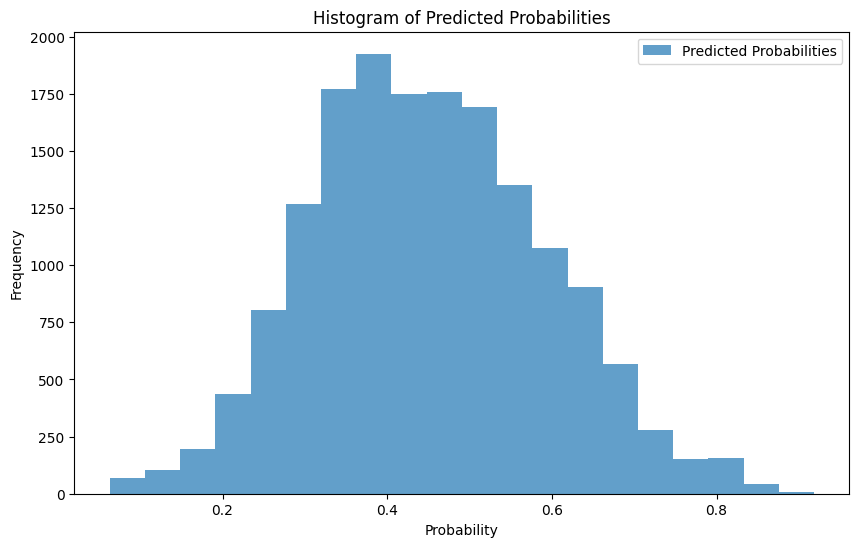

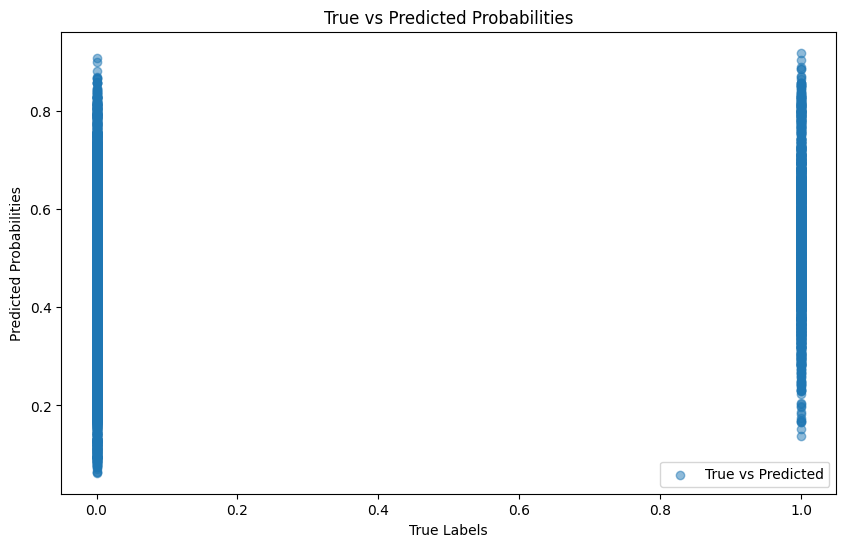

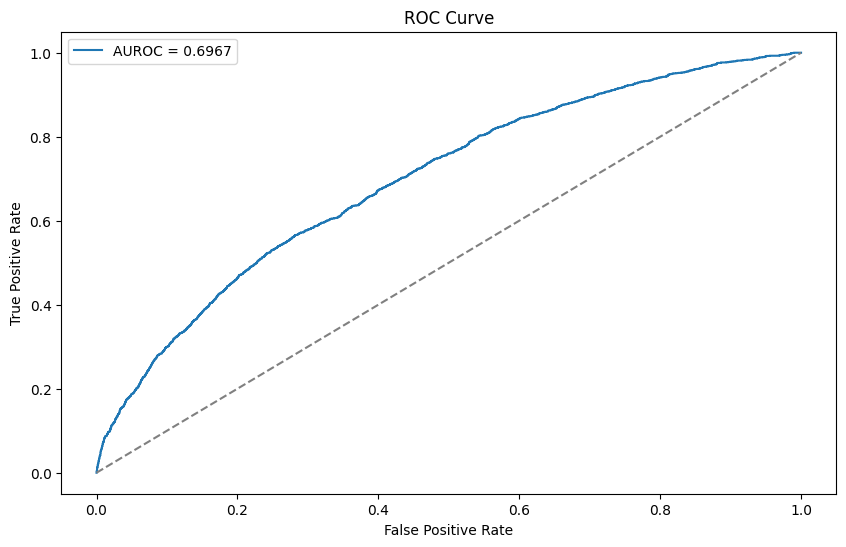

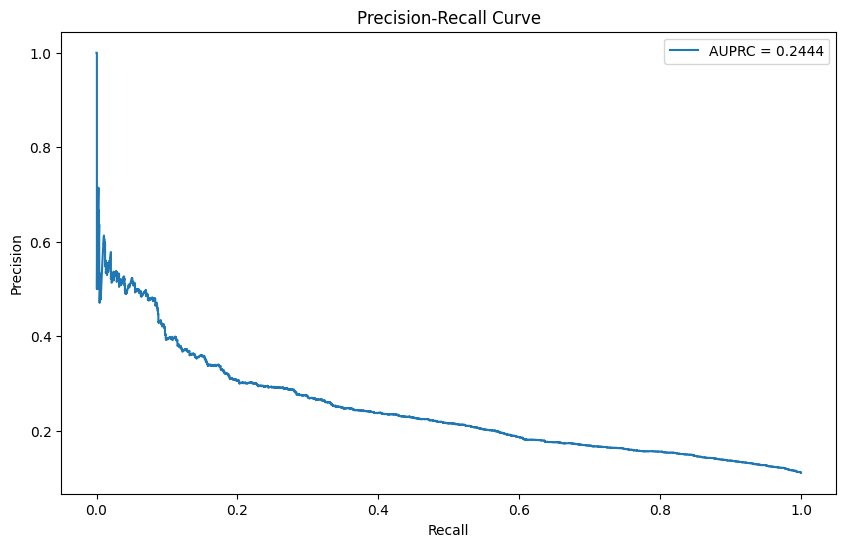

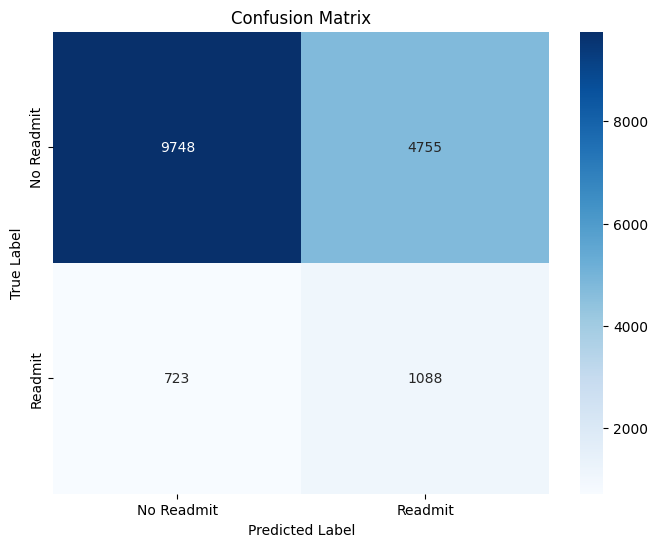

In [11]:
# Calculate metrics for the dev set
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
import matplotlib.pyplot as plt

dev = pd.read_csv(DEV_PATH)

X_dev = dev.drop(columns=["readmit30"])
y_dev = dev["readmit30"].astype(int)

# Calculate metrics
y_true = y_dev.astype(int)
y_pred = clf.predict_proba(X_dev)[:, 1]

auroc = roc_auc_score(y_true, y_pred)
auprc = average_precision_score(y_true, y_pred)
brier = brier_score_loss(y_true, y_pred)

print(f'AUROC: {auroc:.4f}')
print(f'AUPRC: {auprc:.4f}')
print(f'Brier Score: {brier:.4f}')

# Create figures
plt.figure(figsize=(10, 6))

# Histogram of predicted probabilities
plt.hist(y_pred, bins=20, alpha=0.7, label='Predicted Probabilities')
plt.title('Histogram of Predicted Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Scatter plot of true vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5, label='True vs Predicted')
plt.title('True vs Predicted Probabilities')
plt.xlabel('True Labels')
plt.ylabel('Predicted Probabilities')
plt.legend()
plt.show()

# Create ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUROC = {auroc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Create Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label=f'AUPRC = {auprc:.4f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Create Confusion Matrix Heatmap
from sklearn.metrics import confusion_matrix
import seaborn as sns

threshold = 0.5  # Default threshold for binary classification
y_pred_binary = (y_pred >= threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Readmit', 'Readmit'], yticklabels=['No Readmit', 'Readmit'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#MAINEND

## 5) Validate the predictions file format

This checks:
- required columns
- probabilities in [0, 1]
- row_ids match the test file

It assumes the submission notebook wrote `predictions.csv` in the repo root.


In [ ]:
from pathlib import Path
pred_path = Path("predictions.csv")
test_path = Path("Project-1/readmit30/scripts/data/public/public_test.csv")

if not pred_path.exists():
    print("predictions.csv not found. Run notebooks/submission.ipynb first.")
else:
    !python Project-1/readmit30/scripts/validate_submission.py --pred predictions.csv --test Project-1/readmit30/scripts/data/public/public_test.csv


OK: predictions.csv format is valid.


## 6) Commit + push + tag

You will:
- add changes
- commit (pre-commit hook runs here)
- push
- tag a milestone (example: `milestone_wk3`) and push tags



You will need a Personal Access Token (PAT) for the following step. See instructions above.

In [ ]:
# ==== Colab -> GitHub commit/push for a specific notebook path (PAT auth) ====
# What this does:
#  1) clones the repo into the Colab VM
#  2) overwrites the target notebook file with the *currently open* Colab notebook
#  3) commits the change
#  4) asks you for a GitHub PAT and pushes to the target branch
#  5) (optional) creates a git tag and pushes the tag
#
# Notes:
#  - PAT is read via getpass (not echoed). It is only used for this runtime session.
#  - This overwrites the file at TARGET_REL with the *current Colab notebook contents*.

import os
import json
import subprocess
import getpass
from google.colab import _message

# ==========================
# START USER-EDITABLE SETTINGS
# ==========================
# Repo settings
REPO_HTTPS = "https://github.com/TLKline/AIHC-5010-Winter-2026.git"  # full https clone URL ending in .git
REPO_DIR   = "AIHC-5010-Winter-2026"                                # folder name to clone into (or reuse)

# Git settings
BRANCH     = "main"                                                 # branch to commit/push to
COMMIT_MSG = "Update Assignment1_Colab_Workflow.ipynb from Colab test5"    # commit message

# File to overwrite inside the repo (relative to repo root)
TARGET_REL = "Project-1/readmit30/notebooks/Assignment1_Colab_Workflow.ipynb"

# Identity for commits
GIT_USER_NAME  = "Timothy Kline"
GIT_USER_EMAIL = "kline.timothy@mayo.edu"

# (Optional) If you want to push to a different remote than REPO_HTTPS, set it here.
# Leave as None to use REPO_HTTPS.
PUSH_REMOTE_HTTPS = None  # e.g. "https://github.com/<user>/<repo>.git"

# Set TAG_NAME to something like "assignment1-submission-v1".
# Leave as "" (empty string) to skip tagging.
TAG_NAME    = "assignment1-submission-v01"  # e.g. "assignment1-submission-v1"
TAG_MESSAGE = "Assignment 1 submission"  # used only for annotated tags
TAG_ANNOTATED = True  # True = annotated tag (-a -m). False = lightweight tag.
# ==========================
# END USER-EDITABLE SETTINGS
# ==========================


def run(cmd, cwd=None, check=True):
    """Run a shell command and stream output."""
    print(f"\n$ {' '.join(cmd)}")
    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True)
    if p.stdout:
        print(p.stdout)
    if p.stderr:
        print(p.stderr)
    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed with exit code {p.returncode}: {' '.join(cmd)}")
    return p


def github_authed_remote(https_remote: str, token: str) -> str:
    """
    Convert https://github.com/OWNER/REPO.git into https://TOKEN@github.com/OWNER/REPO.git
    Works for standard GitHub HTTPS remotes.
    """
    if https_remote.startswith("https://"):
        return "https://" + token + "@" + https_remote[len("https://"):]
    raise ValueError("Expected an https remote URL (starting with https://).")


def tag_exists_locally(tag_name: str, cwd: str) -> bool:
    p = subprocess.run(["git", "tag", "-l", tag_name], cwd=cwd, text=True, capture_output=True)
    return p.stdout.strip() == tag_name


REMOTE_FOR_PUSH = PUSH_REMOTE_HTTPS or REPO_HTTPS

# 1) Clone (or reuse existing clone)
if not os.path.isdir(REPO_DIR):
    run(["git", "clone", REPO_HTTPS, REPO_DIR])
else:
    print(f"Repo directory already exists: {REPO_DIR}")

# Ensure we're on the right branch and up-to-date
run(["git", "checkout", BRANCH], cwd=REPO_DIR)
run(["git", "pull", "origin", BRANCH], cwd=REPO_DIR)

# 2) Get the currently-open notebook JSON from Colab
nb = _message.blocking_request("get_ipynb", timeout_sec=30)["ipynb"]

# 3) Overwrite the target file in the clone
target_abs = os.path.join(os.getcwd(), REPO_DIR, TARGET_REL)
os.makedirs(os.path.dirname(target_abs), exist_ok=True)
with open(target_abs, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=1)

print("Wrote current Colab notebook to:")
print(" ", target_abs)

# 4) Configure git identity
run(["git", "config", "user.name", GIT_USER_NAME], cwd=REPO_DIR)
run(["git", "config", "user.email", GIT_USER_EMAIL], cwd=REPO_DIR)

# 5) Show status; if no changes, stop early
status = run(["git", "status", "--porcelain"], cwd=REPO_DIR, check=True).stdout.strip()
if not status:
    print("\nNo changes detected in the repo after writing the notebook.")
    print("Double-check that you're running this cell inside the notebook you edited,")
    print("and that TARGET_REL points to the correct path inside the repo.")
else:
    # 6) Add + commit
    run(["git", "add", TARGET_REL], cwd=REPO_DIR)

    commit_proc = subprocess.run(
        ["git", "commit", "-m", COMMIT_MSG],
        cwd=REPO_DIR, text=True, capture_output=True
    )
    if commit_proc.stdout:
        print(commit_proc.stdout)
    if commit_proc.stderr:
        print(commit_proc.stderr)

    combined = (commit_proc.stdout + commit_proc.stderr).lower()
    if commit_proc.returncode != 0 and "nothing to commit" not in combined:
        raise RuntimeError("git commit failed unexpectedly")

    # 7) Ask for PAT and push
    print("\nEnter a GitHub Personal Access Token (PAT) with permission to push to this repo.")
    print("Recommended: fine-grained token with access to the repo and Contents: Read/Write.")
    token = getpass.getpass("GitHub PAT (input hidden): ").strip()
    if not token:
        raise ValueError("No token entered.")

    # Temporarily set authenticated remote URL for this push only (and for tag push)
    authed_remote = github_authed_remote(REMOTE_FOR_PUSH, token)
    run(["git", "remote", "set-url", "origin", authed_remote], cwd=REPO_DIR)

    try:
        # Push commits
        run(["git", "push", "origin", BRANCH], cwd=REPO_DIR)
        print(f"\n Pushed successfully to {BRANCH}.")

        # 8) OPTIONAL: Create + push tag
        if TAG_NAME.strip():
            tag_name = TAG_NAME.strip()

            # If tag already exists locally, don't recreate
            if tag_exists_locally(tag_name, REPO_DIR):
                print(f"Tag already exists locally: {tag_name}")
            else:
                if TAG_ANNOTATED:
                    run(["git", "tag", "-a", tag_name, "-m", TAG_MESSAGE], cwd=REPO_DIR)
                else:
                    run(["git", "tag", tag_name], cwd=REPO_DIR)
                print(f"Created tag: {tag_name}")

            # Push just this tag (or use --tags to push all tags)
            run(["git", "push", "origin", tag_name], cwd=REPO_DIR)
            print(f" Pushed tag: {tag_name}")
        else:
            print("Skipping tag creation (TAG_NAME is empty).")

        print("\nDone. Check GitHub for the new commit (and tag, if set).")

    finally:
        # Restore remote URL without token
        run(["git", "remote", "set-url", "origin", REPO_HTTPS], cwd=REPO_DIR, check=False)



$ git clone https://github.com/TLKline/AIHC-5010-Winter-2026.git AIHC-5010-Winter-2026
Cloning into 'AIHC-5010-Winter-2026'...


$ git checkout main
Your branch is up to date with 'origin/main'.

Already on 'main'


$ git pull origin main


## Done ✅

If you hit issues:
- Make sure you pulled the latest course template (missing files).
- Make sure `data/public/*` exists in your repo (or your instructor provided it separately).
